# Librerías

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ['TF_ENABLE_ONEDNN_OPTS'] =  "0"



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2.14.0


In [3]:
## Uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# Datos

In [ ]:
## Obtener todas las rutas de las imágenes en el dataset
rutas_dataset  = glob.glob('/data/Materiales/Micrografías segmentaciones/secas/*/*/*/*.jpg')

## Separar rutas
mask_list = []
image_list = []
for ruta in rutas_dataset:    
    ruta_list = ruta.split('/')       
    clase = ruta_list[5]
    number = ruta_list[6]
    tipo = ruta_list[7]
    name = ruta_list[8].split('.')[0]
    
    if tipo == 'train':
        image_list.append([name,ruta,clase,number])
    elif tipo == 'mask_bin':
        mask_list.append([name,ruta,clase,number])
    else:
        None

mask_pd = pd.DataFrame(mask_list,columns=['name','route_mask','label','number']).sort_values(by='name')
image_pd = pd.DataFrame(image_list,columns=['name','route_image','label','number']).sort_values(by='name')

routes_dataset = image_pd.merge(mask_pd,on=['name','label','number'],how='left')

routes_dataset.dropna(inplace=True)

routes_dataset = routes_dataset.sample(frac = 1,random_state=42)

print('Imágenes secas:', np.shape(routes_dataset)[0])
print('MF1:', np.shape(routes_dataset[routes_dataset['label']=='MF1'])[0])
print('MF2:', np.shape(routes_dataset[routes_dataset['label']=='MF2'])[0])
print('MF3:', np.shape(routes_dataset[routes_dataset['label']=='MF3'])[0])

char_to_num = {'MF1':'0','MF2':'1','MF3':'2'}

routes_dataset['label'].replace(char_to_num,inplace=True)

routes_dataset

Imágenes secas: 923
MF1: 378
MF2: 284
MF3: 261


/tmp/ipykernel_254468/3933331255.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  routes_dataset['label'].replace(char_to_num,inplace=True)


,name,route_image,label,number,route_mask
608,IMG_20230711_165654_jpg,/data/Materiales/Micrografías segmentaciones/s...,1,4,/data/Materiales/Micrografías segmentaciones/s...
358,IMG_20230707_180920_jpg,/data/Materiales/Micrografías segmentaciones/s...,0,5,/data/Materiales/Micrografías segmentaciones/s...
591,IMG_20230711_163557_jpg,/data/Materiales/Micrografías segmentaciones/s...,1,3,/data/Materiales/Micrografías segmentaciones/s...
815,IMG_20230711_212302_jpg,/data/Materiales/Micrografías segmentaciones/s...,2,7,/data/Materiales/Micrografías segmentaciones/s...
725,IMG_20230711_182428_jpg,/data/Materiales/Micrografías segmentaciones/s...,1,7,/data/Materiales/Micrografías segmentaciones/s...
...,...,...,...,...,...
450,IMG_20230707_191619_jpg,/data/Materiales/Micrografías segmentaciones/s...,0,7,/data/Materiales/Micrografías segmentaciones/s...
355,IMG_20230707_180859_jpg,/data/Materiales/Micrografías segmentaciones/s...,0,5,/data/Materiales/Micrografías segmentaciones/s...
438,IMG_20230707_191415_jpg,/data/Materiales/Micrografías segmentaciones/s...,0,7,/data/Materiales/Micrografías segmentaciones/s...
131,IMG_20230707_162201_jpg,/data/Materiales/Micrografías segmentaciones/s...,0,1,/data/Materiales/Micrografías segmentaciones/s...


In [5]:
## Establecer el porcentaje de separación
thold1 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='0'])))
thold2 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='1'])))
thold3 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='2'])))

## Separar por clases para entrenamiento
train_cu1 = routes_dataset[routes_dataset.label == '0'][0:thold1]
train_cu2 = routes_dataset[routes_dataset.label == '1'][0:thold2]
train_cu3 = routes_dataset[routes_dataset.label == '2'][0:thold3]

## tomar las demás imágenes para test
test_cu1 = routes_dataset[routes_dataset.label == '0'][thold1:]
test_cu2 = routes_dataset[routes_dataset.label == '1'][thold2:]
test_cu3 = routes_dataset[routes_dataset.label == '2'][thold3:]


## Constuir un solo dataset de training
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3]).sample(frac=1,random_state=42).reset_index(drop=True)

## Construir un solo dataset de test
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3]).sample(frac=1,random_state=100).reset_index(drop=True)

## Cantidad de muestras por clase
print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

Clase MF1: train:  303 , test:  75
Clase MF2: train:  228 , test:  56
Clase MF3: train:  209 , test:  52


In [6]:
## Function to get contours and features
def get_contours_and_features(binary_map):
    #https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html
    binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_features = []
    for contour in contours:
        error = 1e-5
        moments = cv2.moments(contour)
        cx = moments['m10'] / (moments['m00'] + error)
        cy = moments['m01'] / (moments['m00'] + error)
        center_of_mass = [cx, cy]
        x,y,w,h = cv2.boundingRect(contour)        
        rect_area = w*h
        features = {
            'bounding_box': (x,y,w,h),
            'area': cv2.contourArea(contour),
            'perimeter': cv2.arcLength(contour, True),       
            #'solidity': np.float32(cv2.contourArea(contour))/cv2.convexHull(contour),
            'equivalent_diameter': np.sqrt(4*cv2.contourArea(contour)/np.pi),            
            'moments': moments,
            'center_of_mass': center_of_mass,
            'contour': contour
        }
        contours_features.append(features)
        del features
    #plt.imshow(contours_map, cmap='gray')
    return contours_features

# function to get a determined property from a list of contours features (area by default)
def get_item(contour_features, key='area'):
    areas = []
    for contour_feature in contour_features:
        area =  contour_feature[key]
        areas.append(area)
    return areas

# function to get tensor of one image
def load_image(file_name):
  raw = tf.io.read_file(file_name)
  tensor = tf.io.decode_jpeg(raw,channels=1)
  tensor = tf.image.resize(tensor, [128,128])
  tensor = tf.cast(tensor, tf.float32) / 255.0
  return tensor

# function to get set of binary image from image loaded
def get_binary_image(filenames):
    tensores = []
    for filename in filenames:
        raw = tf.io.read_file(filename)
        tensor = tf.io.decode_jpeg(raw,channels=3)
        tensor = tf.image.resize(tensor, [128,128])
        tensor = tf.cast(tensor, tf.float32) / 255.0
        tensores.append(tensor)
    return tensores

def get_geometric_atributes(binary_images):
    descriptors = []
    for binary_img in binary_images:
        ## Formato
        image = binary_img.numpy().astype(np.uint8)       
        
        ## Capturar contornos
        contour_features = get_contours_and_features(image)
        
        ## Calcular vector de áreas de poro (todos los poros)
        areas = get_item(contour_features, key='area')

        ## Calcular vector de perímetros de poro (todo los poros)
        pmtro = get_item(contour_features, key='perimeter')

        ## Calcular el diametro equivalente de los poros
        eq_diameter = get_item(contour_features, key='equivalent_diameter')           

        ## Número de poros
        npores = np.shape(areas)[0]

        descriptor = [np.mean(areas), np.mean(pmtro),np.mean(eq_diameter), npores]
        
        descriptors.append(descriptor)
        
    
    return descriptors

def create_dataset(buffer,file_names, labels, file_mask): 
  ## Get binary images   
  masks = get_binary_image(file_mask)
  ## Get geometric atributes from binary images
  attributes = get_geometric_atributes(masks)
  ## Create dataset from tensors assosiated with labels and attributes
  dataset = tf.data.Dataset.from_tensor_slices((file_names,labels,attributes))
  ## Shuffle dataset
  dataset.shuffle(buffer_size=buffer)
  ## Map dataset to load images (a = image, b = label, c = attributes, d = mask)
  dataset = dataset.map(lambda file_name, label, attributes : (load_image(file_name), label, attributes))

  return dataset

file_names = train_df['route_image'].to_numpy()
file_mask = train_df['route_mask'].to_numpy()
labels = train_df['label'].to_numpy()
## Create training dataset using tf.data of 16 images
dataset = create_dataset(16,file_names, labels,file_mask)

2024-07-24 01:46:33.749404: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10394 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:1c:00.0, compute capability: 8.6


[301.84615385  76.54331161  18.49106371  26.        ]
b'0'


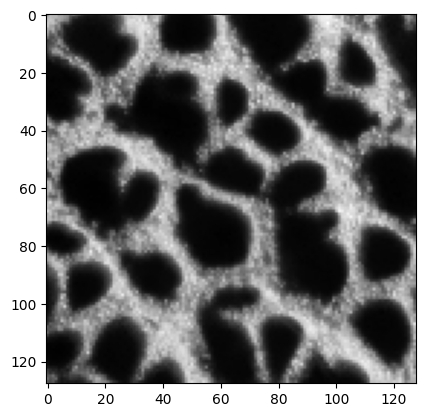

In [8]:
cnt = 0
for i in dataset.batch(16):
    a = i[0]
    b = i[1]
    c = i[2]
    #d = i[3]

n =  0
print(c[n].numpy())
print(b[n].numpy())
plt.imshow(a[n],cmap='gray')
#plt.imshow(d[n],cmap='gray')
plt.show()

# Modelos

In [9]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
###_____________________________ENCODER________________________##
latent_dim = 16

nx, ny = 128, 128

encoder_inputs = keras.Input(shape=(nx, ny,1))

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',name='layer_E1')(encoder_inputs)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',name='layer_E2')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same',name='layer_E3')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same',name='layer_E8')(x)
x = layers.Flatten()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 layer_E1 (Conv2D)           (None, 128, 128, 64)         640       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 64)           0         ['layer_E1[0][0]']            
 g2D)                                                                                             
                                                                                                  
 batch_normalization_3 (Bat  (None, 64, 64, 64)           256       ['max_pooling2d_3[0][0]'

In [13]:
###_____________________________DECODER________________________##
## Entrada Z
latent_inputs = keras.Input(shape=(latent_dim,))

##dimensiones
ndim = 16
nfilts = 128

## anti-flatten de la última capa convolucional
x = layers.Dense(ndim * ndim * nfilts, activation="relu")(latent_inputs)

## Reshape para reconstruir la última convolucional
x = layers.Reshape((ndim,ndim, nfilts))(x)

## Capas convolucionales
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',name='layer_D1')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',name='layer_D2')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same',name='layer_D3')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same',name='layer_D4')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(4, (3, 3), activation='relu', padding='same',name='layer_D5')(x)

decoder_outputs = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='layer_D6')(x)

## Construcción del decoder
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 32768)             557056    
                                                                 
 reshape_1 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 layer_D1 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 up_sampling2d_4 (UpSamplin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                         

In [14]:
###_____________________________Estimador de valores geométricos________________________##

## Input layer
regressor_inputs = keras.Input(shape=(128,128,1))

## Hidden layers
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same',name='layer_R1')(regressor_inputs)
x = layers.MaxPooling2D((2, 2), padding='same',name='layer_R2')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same',name='layer_R3')(x)
x = layers.MaxPooling2D((2, 2), padding='same',name='layer_R4')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same',name='layer_R5')(x)
x = layers.MaxPooling2D((2, 2), padding='same',name='layer_R6')(x)
x = layers.BatchNormalization()(x)

flatten = layers.Flatten()(x)

## Output_1 layer
regressor_output_area = layers.Dense(1, activation="linear")(flatten)

## Output_2 layer
regressor_output_perimeter = layers.Dense(1, activation="linear")(flatten)

## Output_3 layer
regressor_output_diameter = layers.Dense(1, activation="linear")(flatten)

## Output_4 layer
regressor_output_npores = layers.Dense(1, activation="linear")(flatten)

regressor_outputs = [regressor_output_area,regressor_output_perimeter,regressor_output_diameter,regressor_output_npores]

## regressor model
regressor = keras.Model(regressor_inputs, regressor_outputs, name="regressor")
regressor.summary()

Model: "regressor"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 layer_R1 (Conv2D)           (None, 128, 128, 64)         640       ['input_5[0][0]']             
                                                                                                  
 layer_R2 (MaxPooling2D)     (None, 64, 64, 64)           0         ['layer_R1[0][0]']            
                                                                                                  
 batch_normalization_14 (Ba  (None, 64, 64, 64)           256       ['layer_R2[0][0]']            
 tchNormalization)                                                                        

In [15]:
##--------------------- Discriminador entre original y sintético ---------------------##
## Input layer
discriminator_inputs = keras.Input(shape=(128,128,1))

## Hidden layers
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same',name='layer_D1')(discriminator_inputs)
x = layers.MaxPooling2D((2, 2), padding='same',name='layer_D2')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same',name='layer_D3')(x)
x = layers.MaxPooling2D((2, 2), padding='same',name='layer_D4')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same',name='layer_D5')(x)
x = layers.MaxPooling2D((2, 2), padding='same',name='layer_D6')(x)
x = layers.BatchNormalization()(x)

flatten = layers.Flatten()(x)

## Output layer
discriminator_output = layers.Dense(1, activation="sigmoid")(flatten)

## discriminator model
discriminator = keras.Model(discriminator_inputs, discriminator_output, name="discriminator")
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 layer_D1 (Conv2D)           (None, 128, 128, 128)     1280      
                                                                 
 layer_D2 (MaxPooling2D)     (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_17 (Ba  (None, 64, 64, 128)       512       
 tchNormalization)                                               
                                                                 
 layer_D3 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 layer_D4 (MaxPooling2D)     (None, 32, 32, 64)        0         
                                                     

In [16]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, regressor, discriminator, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.regressor = regressor
        self.discriminator = discriminator
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")        
        self.estimation_loss_tracker = keras.metrics.Mean(name="estimation_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="disc_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.estimation_loss_tracker,       
            self.disc_loss_tracker,     
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            ## Valores estimados por el encoder
            z_mean, z_log_var, z = self.encoder(data[0])
            
            ## Valores geométricos asociados a los datos
            geometrics_features = data[2]

            ## Reconstrucción del embebido del encoder
            reconstruction = self.decoder(z)            

            ## Reducción de la reconstrucción
            reconstruction /= tf.reduce_max(reconstruction)

            ## Valores estimados apartir del regresor            
            estimations = self.regressor(reconstruction)       
            
            
            ## Error de reconstrucción
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data[0], reconstruction), axis=(1, 2)
                )
            )
            
            
            

            ## Error de discriminación entre original y reconstrucción
            
                     
            
            ## tomar aleatoriamente la origina lo la recosntruida
            img_type = np.random.randint(0,2)
            
            if img_type == 0:
                
                img  = reconstruction
                disc = self.discriminator(img)
                label = tf.zeros_like(disc)
                
                disc_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(label, disc))
                )
            else:
                img = data[0]
                disc = self.discriminator(img)
                label = tf.ones_like(disc)
                
                disc_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(label, disc))
                )
                
            
            

            
            ## Error de estimación de valores geométricos
                        
            estimation_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(geometrics_features, estimations), axis=(0)
                )
            )
            
            
            ## Error de divergencia KL
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))   
            
            ## factores            
            lmda = 0.9 # vae percentage
            gamma = 5000 # discriminator
            

            ## Error total          
            total_loss = lmda*reconstruction_loss + (1-lmda)*kl_loss + estimation_loss + gamma*disc_loss
        
        ## Actualización de los gradientes
        grads = tape.gradient(total_loss, self.trainable_weights)

        ## Actualización de lA RECONSTRUCCIÓN
        self.reconstruction = reconstruction

        ### Actualización de los pesos
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)   
        self.estimation_loss_tracker.update_state(estimation_loss)  
        self.disc_loss_tracker.update_state(disc_loss)  
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(), 
            "ArithmeticError": self.estimation_loss_tracker.result(),       
            "BinaryError": self.disc_loss_tracker.result(),
        }

In [17]:
vae = VAE(encoder, decoder,regressor,discriminator)
opt = tf.optimizers.Adam(learning_rate = 0.000001)
#nll = lambda x , rv_x: -rv_x.log_prob(x)
vae.compile(optimizer=opt)


vae.fit(dataset.batch(16), epochs=2000, 
                batch_size=16,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)])

Epoch 1/2000


2024-07-24 01:58:07.489914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-07-24 01:58:08.688342: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f53b4076c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-24 01:58:08.688380: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A2000 12GB, Compute Capability 8.6
2024-07-24 01:58:08.696663: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-24 01:58:08.945719: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/47 [==============================] - 17s 80ms/step - loss: 133247.0706 - reconstruction_loss: 44750.0586 - kl_loss: 0.0104 - ArithmeticError: 38146.0929 - BinaryError: 10.9536
Epoch 2/2000
47/47 [==============================] - 2s 42ms/step - loss: 131914.0469 - reconstruction_loss: 44150.0781 - kl_loss: 0.0106 - ArithmeticError: 38143.0698 - BinaryError: 10.8225
Epoch 3/2000
47/47 [==============================] - 2s 44ms/step - loss: 131331.7760 - reconstruction_loss: 44034.8711 - kl_loss: 0.0110 - ArithmeticError: 38139.9360 - BinaryError: 10.6978
Epoch 4/2000
47/47 [==============================] - 2s 43ms/step - loss: 130379.0044 - reconstruction_loss: 43548.8867 - kl_loss: 0.0114 - ArithmeticError: 38136.7682 - BinaryError: 10.5730
Epoch 5/2000
47/47 [==============================] - 2s 43ms/step - loss: 129542.1045 - reconstruction_loss: 43280.4727 - kl_loss: 0.0117 - ArithmeticError: 38133.5418 - BinaryError: 10.4442
Epoch 6/2000
47/47 [==============================] 

In [18]:
### Guardar modelohttps://www.tensorflow.org/guide/saved_model?hl=es-419
vae.encoder.save('Models2/weakly_disc_deep_GVAE_encoder_DRY_2_16.h5')
vae.decoder.save('Models2/weakly_disc_deep_GVAE_decoder_DRY_2_16.h5')
vae.regressor.save('Models2/weakly_disc_deep_GVAE_regressor_DRY_2_16.h5')
vae.discriminator.save('Models2/weakly_disc_deep__GVAE_discriminator_DRY_2_16.h5')

## 1 -> todos los factores en 1 y lmda = 0.5
## 2 -> ,
## factores
            #betha = 5 ## b-vae
            #lmda = 0.9 # vae percentage
            #gamma = 100 # discriminator
            #alpha = 0.05 # estimation
            
## 3 -> 
## factores
            #betha = 5 ## b-vae
            #lmda = 0.9 # vae percentage
            #gamma = 1000 # discriminator
            #alpha = 0.05 # estimation
            
            
## 4 ->
## factores            
           #lmda = 0.9 # vae percentage
           #gamma = 5000 # discriminator

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
